In [1]:
from IPython.display import Image,clear_output
!pip install torch torchvision matplotlib albumentations opencv-python segmentation-models-pytorch
!pip install roboflow
clear_output()

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="4QwtaiJqX1nqiPdAyXcV")
dataset = rf.workspace("dron-hkv6n").project("clasificacion-de-suelo-2").version(7).download("png-mask-semantic", location="/content/my-datasets")


loading Roboflow workspace...
loading Roboflow project...


In [3]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

In [4]:
dataset_path = "/content/my-datasets"

# Rutas de las carpetas
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
valid_path = os.path.join(dataset_path, "valid")

# Obtener listas de archivos
def get_image_mask_paths(folder):
    # Filtrar solo imágenes originales (sin _mask)
    image_files = sorted([f for f in os.listdir(folder) if f.endswith((".jpg", ".png")) and "_mask" not in f])

    # Generar nombres de las máscaras correctamente
    mask_files = [img.rsplit(".", 1)[0] + "_mask.png" for img in image_files]

    return image_files, mask_files

train_images, train_masks = get_image_mask_paths(train_path)
test_images, test_masks = get_image_mask_paths(test_path)
valid_images, valid_masks = get_image_mask_paths(valid_path)

print(f"Entrenamiento: {len(train_images)} imágenes")
print(f"Validación: {len(valid_images)} imágenes")
print(f"Prueba: {len(test_images)} imágenes")

Entrenamiento: 150 imágenes
Validación: 22 imágenes
Prueba: 10 imágenes


In [5]:
import pandas as pd

# Leer el archivo CSV
classes_csv = "/content/my-datasets/train/_classes.csv"
classes_df = pd.read_csv(classes_csv)

# Obtener el número de clases
num_classes = len(classes_df)
print(f"Número de clases en segmentación: {num_classes}")
print(classes_df)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\María Fernanda\AppData\Roamin

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\María Fernanda\AppData\Roamin

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



Número de clases en segmentación: 5
   Pixel Value              Class
0            0         background
1            1               agua
2            2     suelo expuesto
3            3    vegetacion seca
4            4   vegetacion verde


In [50]:
class SoilDataset(Dataset):
    def __init__(self, folder, image_files, mask_files, transform=None):
        self.folder = folder
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.image_files[idx])
        mask_path = os.path.join(self.folder, self.mask_files[idx])

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Imagen no encontrada: {img_path}")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Máscara no encontrada: {mask_path}")

        # Cargar imagen y máscara
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Mantener valores originales

        if mask is None:
            raise ValueError(f"Error al cargar la máscara: {mask_path}")

        # Convertir máscara a `int64` antes de las transformaciones
        mask = mask.astype(np.int64)

        # Aplicar transformaciones de Albumentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)  # Ahora no convertimos a numpy
            image, mask = augmented["image"], augmented["mask"]

        # Asegurar que la máscara es `torch.LongTensor`
        mask = mask.long()

        return image, mask

In [51]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.5),
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [52]:
train_dataset = SoilDataset("/content/my-datasets/train", train_images, train_masks, transform)
valid_dataset = SoilDataset("/content/my-datasets/valid", valid_images, valid_masks, transform)
test_dataset = SoilDataset("/content/my-datasets/test", test_images, test_masks, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Shape de la imagen: torch.Size([3, 256, 256])
Shape de la máscara: torch.Size([256, 256])


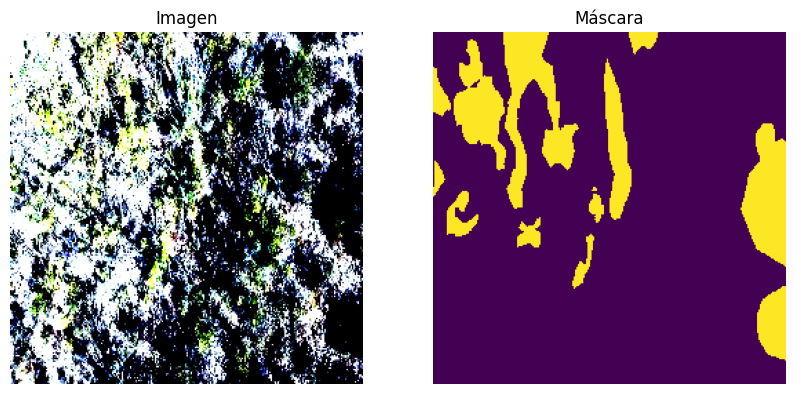

In [53]:
image, mask = train_dataset[0]

print(f"Shape de la imagen: {image.shape}")
print(f"Shape de la máscara: {mask.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))  # Convertir a formato (H, W, C)
plt.title("Imagen")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Máscara")
plt.axis("off")

plt.show()

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes  # Usamos el número de clases desde `_classes.csv`
)

model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [55]:
from segmentation_models_pytorch.losses import FocalLoss
loss_fn = FocalLoss(mode="multiclass", alpha=0.5, gamma=2.0)  # Para segmentación multiclase
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [56]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # Salida: (batch, num_classes, H, W)
        loss = loss_fn(outputs, masks)  # No necesitamos `unsqueeze(1)` en multiclase
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Época {epoch+1}/{num_epochs}, Pérdida: {train_loss/len(train_loader):.4f}")

Época 1/25, Pérdida: 0.3986
Época 2/25, Pérdida: 0.2219
Época 3/25, Pérdida: 0.1834
Época 4/25, Pérdida: 0.1714
Época 5/25, Pérdida: 0.1673
Época 6/25, Pérdida: 0.1646
Época 7/25, Pérdida: 0.1640
Época 8/25, Pérdida: 0.1560
Época 9/25, Pérdida: 0.1606
Época 10/25, Pérdida: 0.1641
Época 11/25, Pérdida: 0.1651
Época 12/25, Pérdida: 0.1472
Época 13/25, Pérdida: 0.1575
Época 14/25, Pérdida: 0.1552
Época 15/25, Pérdida: 0.1597
Época 16/25, Pérdida: 0.1567
Época 17/25, Pérdida: 0.1496
Época 18/25, Pérdida: 0.1564
Época 19/25, Pérdida: 0.1473
Época 20/25, Pérdida: 0.1364
Época 21/25, Pérdida: 0.1377
Época 22/25, Pérdida: 0.1432
Época 23/25, Pérdida: 0.1342
Época 24/25, Pérdida: 0.1379
Época 25/25, Pérdida: 0.1492


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


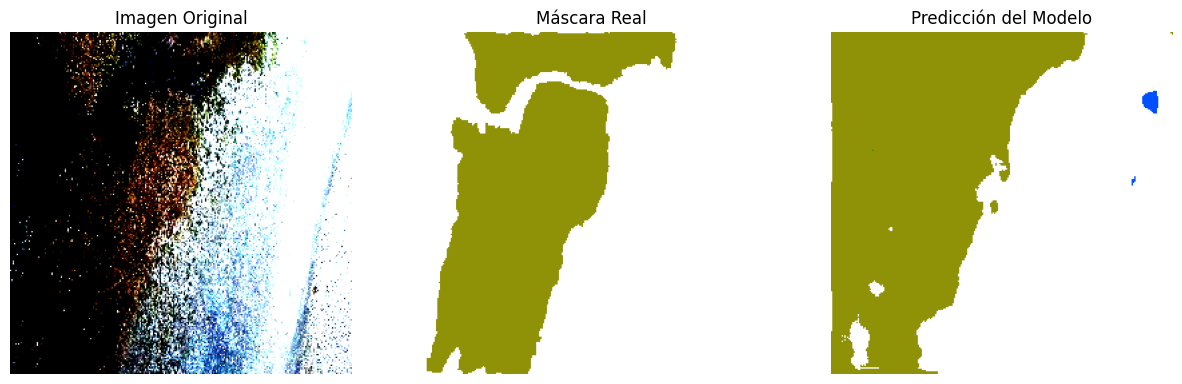

In [57]:
from matplotlib.colors import ListedColormap

# Definir colores personalizados para cada clase
custom_colors = [
    "#000000",  # 0 - Background (Negro)
    "#004fff",  # 1 - Agua (Azul)
    "#FFFFFF",  # 2 - Suelo Expuesto (Marrón)
    "#8f9107",  # 3 - Vegetación Seca (Naranja)
    "#08920a",  # 4 - Vegetación Verde (Verde)
]

# Crear un colormap personalizado
custom_cmap = ListedColormap(custom_colors)

# Visualizar segmentación con los colores personalizados
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # Seleccionar la clase más probable

        # Convertir a NumPy para graficar
        image_np = images[0].cpu().permute(1, 2, 0).numpy()
        mask_np = masks[0].cpu().numpy()
        pred_np = preds[0].cpu().numpy()

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title("Imagen Original")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_np, cmap=custom_cmap, vmin=0, vmax=len(custom_colors)-1)
        plt.title("Máscara Real")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_np, cmap=custom_cmap, vmin=0, vmax=len(custom_colors)-1)
        plt.title("Predicción del Modelo")
        plt.axis("off")

        plt.show()
        break

In [58]:
def compute_dice(preds, masks, num_classes=5):
    preds = torch.argmax(preds, dim=1)  # Convertir logits a clases
    dice_per_class = []

    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().float()
        dice = (2. * intersection + 1e-6) / ((preds == cls).sum().float() + (masks == cls).sum().float() + 1e-6)
        dice_per_class.append(dice.item())

    return sum(dice_per_class) / num_classes  # Promedio del F1 Score (Dice)

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

In [60]:
model.eval()
dice_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # Calcular F1 Score (Dice)
        dice_scores.append(compute_dice(outputs, masks, num_classes=5))

# Promediar los valores obtenidos
final_dice_score = sum(dice_scores) / len(dice_scores)
print(f"\nF1 Score (Dice Score): {final_dice_score:.4f}")


F1 Score (Dice Score): 0.7876


In [61]:
def generate_confusion_report(model, test_loader, num_classes=5, class_labels=None, device="cuda"):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Convertir logits a clases

            all_preds.extend(preds.cpu().numpy().flatten())
            all_masks.extend(masks.cpu().numpy().flatten())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    # Generar reporte de clasificación
    report = classification_report(all_masks, all_preds, target_names=class_labels, digits=4)

    return cm, report

In [62]:
class_labels = ["Agua", "Suelo Expuesto", "Vegetación Seca", "Vegetación Verde"]

In [63]:
# Generar reporte de matriz de confusión y clasificación
cm, report = generate_confusion_report(model, test_loader, num_classes=4, class_labels=class_labels, device=device)

In [64]:
print("\nReporte de Clasificación:")
print(report)


Reporte de Clasificación:
                  precision    recall  f1-score   support

            Agua     0.0796    0.1402    0.1016      5035
  Suelo Expuesto     0.8866    0.7335    0.8028    252935
 Vegetación Seca     0.7674    0.9222    0.8377    361660
Vegetación Verde     0.6508    0.0481    0.0895     35730

        accuracy                         0.7957    655360
       macro avg     0.5961    0.4610    0.4579    655360
    weighted avg     0.8018    0.7957    0.7778    655360



In [65]:
# Guardar todo el modelo
torch.save(model, "clasificacion_suelos_2.pth")